In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.core.display import HTML

In [2]:
faults = pd.read_csv('../data/J1939Faults.csv', 
                    usecols=['RecordID',
                             'EventTimeStamp',
                            'eventDescription',
                            'ecuSerialNumber',
                            'ecuSource',
                            'spn',
                            'fmi',
                            'active',
                            'activeTransitionCount',
                            'EquipmentID',
                            'Latitude',
                            'Longitude',
                            'LocationTimeStamp'
                            ])
faults['EventTimeStamp'] = pd.to_datetime(faults['EventTimeStamp'])
faults['LocationTimeStamp'] = pd.to_datetime(faults['LocationTimeStamp'])
faults['EventMonth'] = pd.DatetimeIndex(faults['EventTimeStamp']).month
faults['EquipmentID'] = faults['EquipmentID'].astype(str)
diag = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv')

vehicle = pd.read_excel('../data/Vehicle_Make.xlsx')
fault_code = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
faults[faults['spn']==5246].nunique()

RecordID                 1195
EventTimeStamp           1183
eventDescription            0
ecuSerialNumber           182
ecuSource                   2
spn                         1
fmi                         5
active                      2
activeTransitionCount      54
EquipmentID               215
Latitude                  852
Longitude                 855
LocationTimeStamp        1150
EventMonth                 12
dtype: int64

In [4]:
faults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   RecordID               1187335 non-null  int64         
 1   EventTimeStamp         1187335 non-null  datetime64[ns]
 2   eventDescription       1126490 non-null  object        
 3   ecuSerialNumber        844318 non-null   object        
 4   ecuSource              1187335 non-null  int64         
 5   spn                    1187335 non-null  int64         
 6   fmi                    1187335 non-null  int64         
 7   active                 1187335 non-null  bool          
 8   activeTransitionCount  1187335 non-null  int64         
 9   EquipmentID            1187335 non-null  object        
 10  Latitude               1187335 non-null  float64       
 11  Longitude              1187335 non-null  float64       
 12  LocationTimeStamp      11873

In [46]:
# Full derate with spn 5246 and Active == True
derate = faults[(faults['spn']==5246) & (faults['active']==True) ]

In [47]:
derate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 45 to 1184330
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RecordID               607 non-null    int64         
 1   EventTimeStamp         607 non-null    datetime64[ns]
 2   eventDescription       0 non-null      object        
 3   ecuSerialNumber        498 non-null    object        
 4   ecuSource              607 non-null    int64         
 5   spn                    607 non-null    int64         
 6   fmi                    607 non-null    int64         
 7   active                 607 non-null    bool          
 8   activeTransitionCount  607 non-null    int64         
 9   EquipmentID            607 non-null    object        
 10  Latitude               607 non-null    float64       
 11  Longitude              607 non-null    float64       
 12  LocationTimeStamp      607 non-null    datetime64[ns]
 13  

In [48]:
derate.sort_values(['EquipmentID','EventTimeStamp']).head(20)

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
996835,1032993,2018-07-06 09:42:48,NaN,79903644,0,5246,0,True,1,105349576,36.068564,-79.272268,2018-07-06 09:43:24,7
156410,158796,2015-08-10 10:26:40,NaN,79481949,0,5246,0,True,1,105360462,36.066759,-86.434120,2015-08-10 10:27:17,8
185581,187967,2015-08-31 13:50:42,NaN,79481949,0,5246,0,True,1,105411041,36.066666,-86.434120,2015-08-31 13:51:19,8
972882,1004301,2018-04-27 06:07:55,NaN,79875551,0,5246,0,True,1,105427203,36.466990,-86.687268,2018-04-27 06:08:31,4
5713,5714,2015-02-25 13:53:08,NaN,unknown,0,5246,0,True,1,1329,39.399583,-82.974768,2015-02-25 13:56:31,2
83425,85811,2015-06-12 15:35:22,NaN,unknown,0,5246,0,True,1,1339,37.035324,-86.336018,2015-06-12 15:35:58,6
82772,85158,2015-06-12 06:13:27,NaN,unknown,0,5246,0,True,1,1366,35.146018,-86.578888,2015-06-12 07:17:28,6
83703,86089,2015-06-13 03:33:30,NaN,unknown,0,5246,0,True,1,1366,33.208888,-84.055972,2015-06-13 03:34:06,6
107460,109846,2015-07-03 19:10:35,NaN,79452482,0,5246,0,True,1,1366,35.724212,-86.321296,2015-07-03 19:12:41,7
212164,214550,2015-09-23 10:28:29,NaN,79452482,0,5246,0,True,1,1366,35.151990,-84.954074,2015-09-23 10:29:05,9


In [49]:
derate[derate['EquipmentID']=='1630']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
2089,2090,2015-02-23 05:05:44,NaN,79642446,0,5246,0,True,1,1630,40.733009,-74.087777,2015-02-23 05:08:23,2
861452,884718,2017-10-04 05:56:17,NaN,79642446,0,5246,0,True,1,1630,37.839675,-80.753611,2017-10-04 05:56:52,10


In [50]:
faults[faults['EquipmentID']=='1630']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
66,67,2015-02-21 12:25:26,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
67,68,2015-02-21 12:25:37,Low (Severity High) Engine Coolant Level,79642446,0,111,1,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
68,69,2015-02-21 12:25:44,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,35.587592,-86.443796,2015-02-21 12:27:09,2
80,81,2015-02-21 12:33:52,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,35.586944,-86.443657,2015-02-21 12:33:48,2
82,83,2015-02-21 12:35:04,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,False,3,1630,35.586712,-86.443611,2015-02-21 12:35:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951045,980571,2018-03-09 09:42:56,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066759,-86.434027,2018-03-09 09:42:52,3
951046,980572,2018-03-09 09:43:15,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066759,-86.434166,2018-03-09 09:43:52,3
951048,980574,2018-03-09 09:51:47,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066712,-86.434166,2018-03-09 09:51:43,3
955026,984552,2018-03-09 09:52:14,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066342,-86.434722,2018-03-09 17:54:07,3


In [51]:
event_month = pd.DataFrame(derate['EventMonth'].value_counts().to_frame().sort_index().reset_index())

In [52]:
event_month.rename(columns = {'index':'month', 'EventMonth':'full_derate_count'}, inplace=True)

In [53]:
event_month

,month,full_derate_count
0,1,64
1,2,86
2,3,38
3,4,53
4,5,56
5,6,42
6,7,51
7,8,46
8,9,28
9,10,31


In [54]:
event_month.columns

Index(['month', 'full_derate_count'], dtype='object')

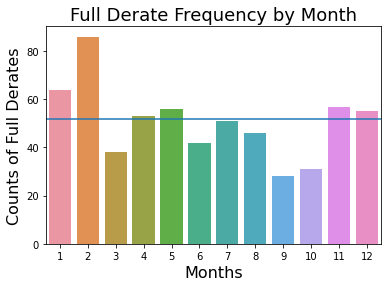

In [79]:
sns.barplot(data = event_month, x= 'month', y = 'full_derate_count').axhline(np.median(event_month['full_derate_count']))
plt.title('Full Derate Frequency by Month', fontsize = 18)
plt.xlabel('Months', fontsize = 16)
plt.ylabel('Counts of Full Derates', fontsize = 16);
plt.savefig("derate_month.png", dpi = 300)


In [56]:
# diag_pivoted = pd.pivot_table(diag, columns= ['Name'], values = 'Value', index = 'FaultId', aggfunc= 'first').reset_index()

# faults_diag = faults.merge(diag_pivoted, left_on = 'RecordID', right_on = 'FaultId')

# derate = faults_diag[faults_diag['spn']==5246]

In [57]:
from folium import plugins
from folium.plugins import HeatMap


map_hooray = folium.Map(location=[35.860119, -86.660156],
                    zoom_start = 5) 

heat_df = derate[['Latitude','Longitude']]

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# render HTML
map_hooray.save('derate_location.html')

# Display the map
map_hooray

In [58]:
derated_truck_ID = derate['EquipmentID'].unique()

In [59]:
derated_truck_ID

array(['1395', '1630', '1487', '1329', '1419', '1486', '1509', '1492',
       '1473', '1383', '1396', '1602', '1431', '1795', '1595', '1366',
       '1339', '1391', '1399', '1417', '1591', '1490', '1547', '1444',
       '1457', '105360462', '1437', '1453', '1584', '1692', '105411041',
       '1590', '1398', '1418', '1472', '1560', '1572', '1375', '1742',
       '1566', '1778', '1524', '305', '1659', '1403', '1535', '1567',
       '1373', '1665', '1551', '1440', '1571', '1443', '1378', '1452',
       '1488', '1384', '304', '1582', '1508', '1599', '1501', '1407',
       '1603', '1604', '1477', '1389', '1519', '1757', '1458', '1401',
       '1467', '1579', '1534', '1575', '1539', '1601', '1657', '1592',
       '1563', '1557', '1605', '1581', '301', '1811', '1573', '1594',
       '1668', '1643', '1561', '1549', '1940', '1839', '1552', '1637',
       '1554', '1529', '1686', '1598', '1828', '1745', '1525', '1848',
       '1537', '1521', '1661', '1831', '1528', '1654', '1917', '1543',
       

In [60]:
derated_truck = faults[faults['EquipmentID'].isin(derated_truck_ID)]

In [61]:
# most common spn for derated trucks
derated_truck['spn'].value_counts()

# 111 Low (Severity Medium) Engine Coolant Level
# 929 Abnormal Update Rate Tire Location
# 96 High Voltage (Fuel Level)
# 829 High Voltage (Left Fuel Level Sensor)
# 639 Incorrect Data J1939 Network #1 Primary Vehicl...


111     180905
929      38510
96       32579
829      30108
639       8621
         ...  
3227         2
810          2
3521         1
3241         1
3663         1
Name: spn, Length: 342, dtype: int64

In [62]:
derated_truck[derated_truck['spn']==639]

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
2520,2521,2015-02-23 10:47:07,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,1768,36.067037,-86.434351,2015-02-23 10:01:55,2
2527,2528,2015-02-23 10:54:20,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,False,127,1768,36.067037,-86.434768,2015-02-23 10:52:22,2
5778,5779,2015-02-25 14:23:20,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,1621,39.945277,-82.536620,2015-02-25 14:23:56,2
5807,5808,2015-02-25 14:45:09,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,False,127,1621,39.945370,-82.536064,2015-02-25 14:45:05,2
6618,6619,2015-02-27 08:35:41,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,1605,41.832268,-87.748240,2015-02-27 08:36:17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185363,1246487,2020-02-27 16:50:29,NaN,K1240376,3,639,12,False,22,2089,39.161851,-76.781620,2020-02-27 16:50:30,2
1186388,1247512,2020-03-03 15:34:13,NaN,K1240376,3,639,12,True,26,2089,30.372083,-81.834629,2020-03-03 15:42:17,3
1186389,1247513,2020-03-03 15:42:13,NaN,K1240376,3,639,12,False,26,2089,30.372083,-81.834629,2020-03-03 15:42:18,3
1187241,1248365,2020-03-06 09:23:24,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,2089,29.265370,-82.189629,2020-03-06 09:24:01,3


In [63]:
derated_truck[derated_truck['EquipmentID']=='1395']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
45,46,2015-02-21 12:10:51,NaN,79464664,0,5246,0,True,1,1395,36.065972,-86.433425,2015-02-21 12:11:27,2
1916,1917,2015-02-22 19:44:55,Low Voltage (Aftertreatment 1 Outlet NOx),79464664,0,3226,4,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
1917,1918,2015-02-22 19:44:55,Condition Exists Engine Protection Torque Derate,79464664,0,1569,31,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
1918,1919,2015-02-22 19:44:55,NaN,79464664,0,5246,0,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
1919,1920,2015-02-22 19:44:55,Abnormal Rate of Change Aftertreatment 1 Outle...,79464664,0,3226,10,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439557,447824,2016-04-14 16:43:08,NaN,79464664,0,4364,18,False,1,1395,39.943981,-82.535416,2016-04-14 16:43:04,4
439669,447936,2016-04-14 19:53:32,NaN,79464664,0,4364,18,True,1,1395,38.465138,-85.285601,2016-04-14 19:54:08,4
440600,448867,2016-04-15 14:44:36,Incorrect Data Brake Light Switch 1,Q491011011,11,1045,2,True,127,1395,36.192546,-86.411296,2016-04-15 14:45:13,4
440813,449080,2016-04-15 18:57:09,Incorrect Data Brake Light Switch 1,Q491011011,11,1045,2,False,127,1395,36.179953,-86.297870,2016-04-15 18:57:05,4


In [64]:
derated_truck[derated_truck['EquipmentID']=='1630']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
66,67,2015-02-21 12:25:26,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
67,68,2015-02-21 12:25:37,Low (Severity High) Engine Coolant Level,79642446,0,111,1,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
68,69,2015-02-21 12:25:44,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,35.587592,-86.443796,2015-02-21 12:27:09,2
80,81,2015-02-21 12:33:52,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,35.586944,-86.443657,2015-02-21 12:33:48,2
82,83,2015-02-21 12:35:04,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,False,3,1630,35.586712,-86.443611,2015-02-21 12:35:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951045,980571,2018-03-09 09:42:56,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066759,-86.434027,2018-03-09 09:42:52,3
951046,980572,2018-03-09 09:43:15,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066759,-86.434166,2018-03-09 09:43:52,3
951048,980574,2018-03-09 09:51:47,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066712,-86.434166,2018-03-09 09:51:43,3
955026,984552,2018-03-09 09:52:14,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066342,-86.434722,2018-03-09 17:54:07,3


In [65]:
derated_truck[derated_truck['EquipmentID']=='1487']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
2216,2217,2015-02-23 07:15:48,NaN,unknown,0,4334,3,True,1,1487,25.878518,-80.357222,2015-02-23 07:16:24,2
2217,2218,2015-02-23 07:16:03,Condition Exists Engine Protection Torque Derate,unknown,0,1569,31,True,1,1487,25.878518,-80.357222,2015-02-23 07:16:39,2
2293,2294,2015-02-23 07:56:08,Condition Exists Catalyst Dosing Unit Input Lines,unknown,0,3362,31,True,1,1487,25.861342,-80.371851,2015-02-23 07:56:44,2
2395,2396,2015-02-23 09:16:02,Condition Exists Engine Protection Torque Derate,unknown,0,1569,31,False,1,1487,25.860277,-80.371712,2015-02-23 09:15:58,2
2440,2441,2015-02-23 09:51:41,Condition Exists Engine Protection Torque Derate,unknown,0,1569,31,True,1,1487,25.861898,-80.373101,2015-02-23 09:52:16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540430,553278,2016-08-08 23:47:15,Low (Severity Medium) Engine Coolant Level,79487660,0,111,18,True,1,1487,36.073101,-86.429444,2016-08-08 23:47:52,8
544749,557597,2016-08-14 02:32:32,NaN,79487660,0,5491,5,True,1,1487,36.066898,-86.434120,2016-08-14 02:33:08,8
549997,563615,2016-08-19 14:20:47,Low (Severity Medium) Engine Coolant Level,79929876,0,111,18,False,1,1487,35.588148,-86.443842,2016-08-19 14:20:42,8
549998,563616,2016-08-19 14:20:47,NaN,unknown,49,524033,31,False,9,1487,35.588148,-86.443842,2016-08-19 14:20:42,8


In [66]:
derate.nunique()

RecordID                 607
EventTimeStamp           603
eventDescription           0
ecuSerialNumber          176
ecuSource                  2
spn                        1
fmi                        5
active                     1
activeTransitionCount     39
EquipmentID              213
Latitude                 524
Longitude                529
LocationTimeStamp        597
EventMonth                12
dtype: int64

In [126]:
derate.groupby(['EquipmentID']).size()

EquipmentID
105349576     1
105360462     1
105411041     1
105427203     1
1329          1
             ..
301           3
302           3
304           1
305          14
306           1
Length: 213, dtype: int64

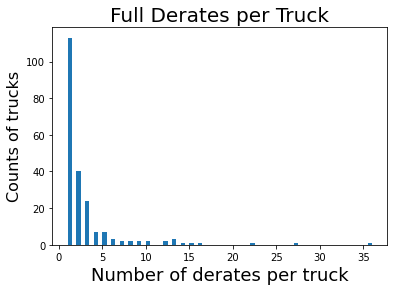

In [77]:
# Frequency of derates
plt.hist(derate.groupby(['EquipmentID']).size().to_list(), bins = 70)
plt.title('Full Derates per Truck', fontsize=20)
plt.xlabel('Number of derates per truck', fontsize=18)
plt.ylabel('Counts of trucks', fontsize=16)
plt.savefig('derate_freq.png', dpi = 300);

In [129]:
derate.groupby(['EquipmentID'])['spn'].count().sort_values(ascending = False)

EquipmentID
1524    36
1535    27
1525    22
1539    16
1749    15
        ..
1599     1
1594     1
1592     1
1590     1
306      1
Name: spn, Length: 213, dtype: int64

In [130]:
derate.groupby('EquipmentID').size().sort_values()

EquipmentID
105349576     1
1731          1
1732          1
1742          1
1743          1
             ..
1749         15
1539         16
1525         22
1535         27
1524         36
Length: 213, dtype: int64

In [117]:
# Percentile of Frequency of Full Derates
for x in range(5, 101, 5):
    derate_quantile = derate.groupby(['EquipmentID']).size().quantile(x/100)
    print(f'{x} percentile', derate_quantile)

5 percentile 1.0
10 percentile 1.0
15 percentile 1.0
20 percentile 1.0
25 percentile 1.0
30 percentile 1.0
35 percentile 1.0
40 percentile 1.0
45 percentile 1.0
50 percentile 1.0
55 percentile 2.0
60 percentile 2.0
65 percentile 2.0
70 percentile 2.0
75 percentile 3.0
80 percentile 3.0
85 percentile 4.0
90 percentile 5.800000000000011
95 percentile 10.799999999999955
100 percentile 36.0


In [71]:
derate['diff'] = derate.sort_values(['EquipmentID','EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
derate["diff"] = derate["diff"].apply(lambda x: x/np.timedelta64(1, 'D')).fillna(0).astype('float')

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


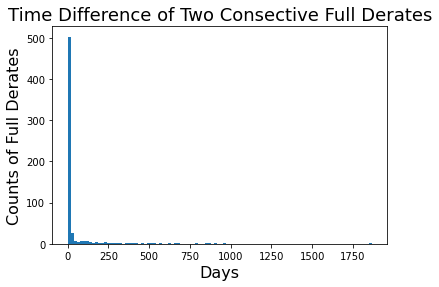

In [73]:
# time difference of full derate
plt.hist(derate['diff'], bins = 100)
plt.title('Time Difference of Two Consective Full Derates', fontsize = 18)
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Counts of Full Derates', fontsize = 16)
plt.savefig('time_diff_derate.png', dpi = 300);

In [102]:
# Percentile of Time Difference Between Two Consecutive Full Derates
for x in range(5, 101, 5):
    derate_quantile = derate['diff'].quantile(x/100)
    print(f'{x} percentile', derate_quantile)

5 percentile 0.0
10 percentile 0.0
15 percentile 0.0
20 percentile 0.0
25 percentile 0.0
30 percentile 0.0
35 percentile 0.0
40 percentile 0.02446296296296297
45 percentile 0.04360185185185185
50 percentile 0.09708333333333333
55 percentile 0.21751736111111114
60 percentile 0.47194444444444417
65 percentile 0.8515543981481482
70 percentile 1.716939814814814
75 percentile 4.608732638888889
80 percentile 10.79882638888889
85 percentile 23.480125
90 percentile 92.58483101851851
95 percentile 231.0477719907407
100 percentile 1866.2725694444443
